# Simple implementation of a CNN

## 1. Training

Run the next 4 cells and it will start training

In [1]:
from matplotlib import pyplot as plt
def show_image_mask(img, mask, cmap='gray'): # visualisation
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')
    plt.show() # draw the images immediatelly

In [2]:
import torch
import torch.utils.data as data
import cv2
import os
from glob import glob

class TrainDataset(data.Dataset):
    def __init__(self, root=''):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        #self.img_files = self.img_files[0:10] # only using part of the dataset
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)

class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float()

    def __len__(self):
        return len(self.img_files)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SimpleHybrid(nn.Module): # Define your model
    def __init__(self):
        super(SimpleHybrid, self).__init__()

        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(  1, 128, 3, padding=1)
        self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
        
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)

        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv6 = nn.Conv2d(512, 512, 3, padding=1)
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners = False)
        
        self.conv7 = nn.Conv2d(512, 256, 3, padding=1)
        self.conv8 = nn.Conv2d(256, 256, 3, padding=1)

        self.conv9  = nn.Conv2d(256, 128, 3, padding=1)
        self.conv10 = nn.Conv2d(128, 128, 3, padding=1)
        
        self.convscores = nn.Conv2d(128, 4, 3, padding=1)
        
    def forward(self, x):
        # fill in the forward function for your model here
        
        x = F.selu(self.conv1(x))
        x = F.selu(self.conv2(x))
        x = F.selu(self.conv2(x))
        
        x = self.pool(x) # now at 48x48 resolution
        
        x = F.selu(self.conv3(x))
        x = F.selu(self.conv4(x))
        x = F.selu(self.conv4(x))

        x = self.pool(x)
        
        x = F.selu(self.conv5(x))
        x = F.selu(self.conv6(x))
        x = F.selu(self.conv6(x))

        #if using ConvTranspose2d, then x = self.upsample(x, output_size=(96,96))
        x = self.upsample(x)
        
        x = F.selu(self.conv7(x))
        x = F.selu(self.conv8(x))
        x = F.selu(self.conv8(x))

        x = self.upsample(x)
        
        x = F.selu(self.conv9(x))
        x = F.selu(self.conv10(x))
        x = F.selu(self.conv10(x))
        
        x = self.convscores(x) # CrossEntropyLoss does softmax inside it
        
        return x

model = SimpleHybrid() # We can now create a model using your defined segmentation model

import torch.optim as optim

Loss = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.0023, momentum=0.3)

#optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.8, 0.9), eps=1e-08, weight_decay=0)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.8)

In [ ]:
from torch.utils.data import DataLoader

data_path = './data/train'
num_workers = 4
batch_size = 4
train_set = TrainDataset(data_path)
training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)

save_network = False

model.train() # switch model to training mode

for epoch in range(1000):
    
    running_loss = 0.0
    
    # Fetch images and labels.  
    for iteration, sample in enumerate(training_data_loader):
        img, mask = sample 
        
        #visualise only the first image in a batch
        #show_image_mask(img[0,...].squeeze(), mask[0,...].squeeze())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        img = img.unsqueeze(1) # model expects data in precise format
        outputs = model(img)
        
        # print(img.size(), '...', mask.size())
        # print(outputs.size(), pred_class.size(), outputs.dtype, pred_class.dtype, mask.dtype)
        
        mask = mask.type(torch.LongTensor)
        
        #print('...>', mask[0,48,48], '...', pred_class[0,0,48,48], '...', outputs[0,:,48,48])
        
        # loss + backward + optimize
        loss = Loss(outputs, mask)
        loss.backward()
        optimizer.step()

        # print stats
        running_loss += loss.item()
        if iteration == 0:
            print('epoch ', epoch, ' iteration ', iteration, ' loss ', running_loss / 24)
            running_loss = 0.0
            
            # draw predicted images next to ground truth masks
            pred_class = torch.argmax(outputs, dim=1)
            pred_class = pred_class.unsqueeze(1)
            show_image_mask(pred_class[0,...].squeeze(), mask[0,...].squeeze())
            
        if save_network:
            if epoch % 50 == 49:
                PATH = './trained_{0}e.pth'.format(epoch)
                torch.save(model.state_dict(), PATH)

            
print('Done training!')

Save the trained neural network

In [ ]:
PATH = './trained_full.pth'
torch.save(model.state_dict(), PATH)

## 2. Evaluation

Load the trained neural network

In [13]:
#PATH = './trained_full_1000e.pth'
PATH = './trained_749e_sgd.pth'

model = SimpleHybrid()
model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

Set up functions to calculate dice score

In [14]:
import numpy as np

def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

def average_dice(mask1, mask2):
    total_dice = (
        categorical_dice(mask1, mask2, 0) +
        categorical_dice(mask1, mask2, 1) +
        categorical_dice(mask1, mask2, 2) +
        categorical_dice(mask1, mask2, 3)
    )
    
    return total_dice / 4.0

Run the network on the val dataset and display the dice scores

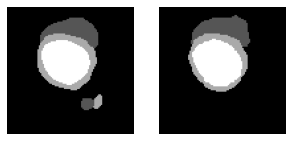

dice 0.8892458377371191


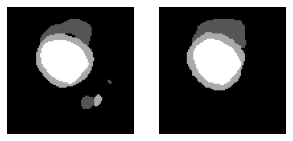

dice 0.8751259042569576


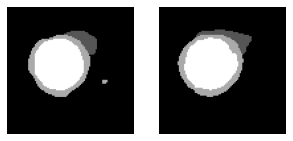

dice 0.8650038719896121


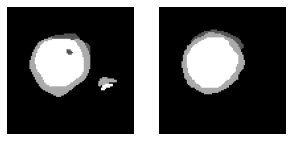

dice 0.7216717298619271


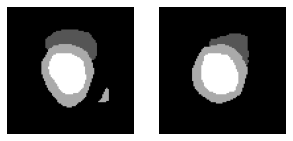

dice 0.861268731295793


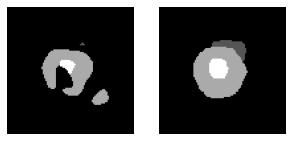

dice 0.590576241997981


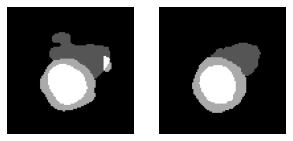

dice 0.8704115377907746


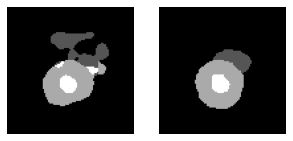

dice 0.7596252641050221


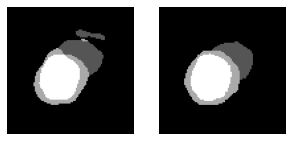

dice 0.8846157001855569


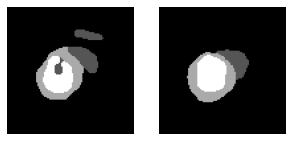

dice 0.7969719015235899


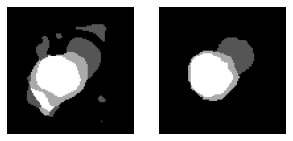

dice 0.7464939521105531


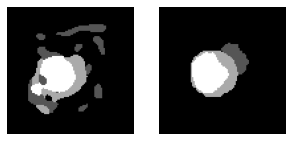

dice 0.6449150437033841


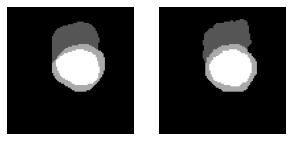

dice 0.9204742859089472


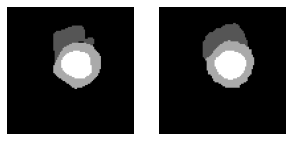

dice 0.9075824331787496


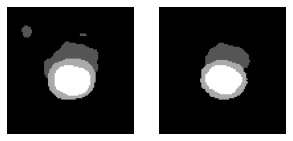

dice 0.8698879528875734


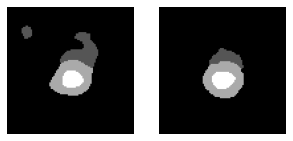

dice 0.8027234111936454


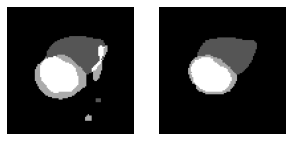

dice 0.8250238837740714


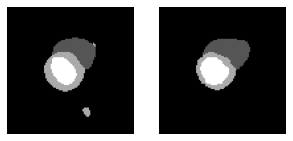

dice 0.8907896215172291


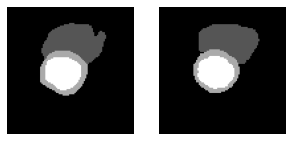

dice 0.9180994788354903


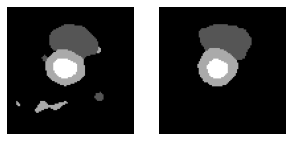

dice 0.8926627603978602
Done val! Dice:  0.8266584772125917


In [15]:
from torch.utils.data import DataLoader

data_path = './data/val'
num_workers = 4
batch_size = 1
val_set = TrainDataset(data_path)
val_data_loader = DataLoader(dataset=val_set, num_workers=num_workers, batch_size=batch_size)

total_dice = 0.0

model.eval() # switch model to evaluation mode

with torch.no_grad():
    
    # Fetch images and labels.
    for iteration, sample in enumerate(val_data_loader):
        img, mask = sample 

        # forward
        img = img.unsqueeze(1)
        outputs = model(img)

        mask = mask.type(torch.LongTensor)
        
        # convert output to predicted class so it can be visualised
        pred_class = torch.argmax(outputs, dim=1)
        show_image_mask(pred_class[0,...].squeeze(), mask[0,...].squeeze())
        
        dice = average_dice(mask[0,...].numpy(), pred_class[0,...].numpy())
        print('dice', dice)
        
        total_dice += dice
        
print('Done val! Dice: ', total_dice / 20.0) # 20 images in val dataset

Run the network on the test dataset and save the masks as png files

In [ ]:
from torch.utils.data import DataLoader

# In this block you are expected to write code to load saved model and deploy it to all data in test set to 
# produce segmentation masks in png images valued 0,1,2,3, which will be used for the submission to Kaggle.
data_path = './data/test'
num_workers = 4
batch_size = 1

test_set = TestDataset(data_path)
test_data_loader = DataLoader(dataset=test_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)

model.eval() # switch model to evaluation mode

with torch.no_grad():
    
    # Fetch images and labels.
    for iteration, sample in enumerate(test_data_loader):
        img = sample

        # forward
        img = img.unsqueeze(1)
        outputs = model(img)

        # convert output to predicted class so it can be visualised
        pred_class = torch.argmax(outputs, dim=1)
        show_image_mask(img[0,...].squeeze(), pred_class[0,...].squeeze())
        
        # save predictions
        mask_filename = 'cmr{0}_mask.png'.format(iteration + 121)
        print('saving as', mask_filename)
        
        pred_img = pred_class[0,...].squeeze().numpy()
        cv2.imwrite(os.path.join('./data/test/mask', mask_filename), pred_img)
        
print('Done test!')

## 3. Submission

Make sure there are no other files in the ./data/test/mask directory. Jupyter creates .ipynb_checkpoints over and over again in that folder

In [ ]:
# list all the files in the directory

import os
print(os.listdir('./data/test/mask'))

Create the submission file

In [ ]:
import numpy as np
import os
import cv2

def rle_encoding(x):
    '''
    *** Credit to https://www.kaggle.com/rakhlin/fast-run-length-encoding-python ***
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def submission_converter(mask_directory, path_to_save):
    writer = open(os.path.join(path_to_save, "submission.csv"), 'w')
    writer.write('id,encoding\n')

    files = os.listdir(mask_directory)

    for file in files:
        name = file[:-4]
        mask = cv2.imread(os.path.join(mask_directory, file), cv2.IMREAD_UNCHANGED)

        mask1 = (mask == 1)
        mask2 = (mask == 2)
        mask3 = (mask == 3)

        encoded_mask1 = rle_encoding(mask1)
        encoded_mask1 = ' '.join(str(e) for e in encoded_mask1)
        encoded_mask2 = rle_encoding(mask2)
        encoded_mask2 = ' '.join(str(e) for e in encoded_mask2)
        encoded_mask3 = rle_encoding(mask3)
        encoded_mask3 = ' '.join(str(e) for e in encoded_mask3)

        writer.write(name + '1,' + encoded_mask1 + "\n")
        writer.write(name + '2,' + encoded_mask2 + "\n")
        writer.write(name + '3,' + encoded_mask3 + "\n")

    writer.close()
    
submission_converter('./data/test/mask', './')
print('Submission done!')